## Tensorflow Probability - Bayesian Linear Models   
### Day 13/100 Days of TensorFlow Probability  

Now we're flying. In our last notebook we figured out how to run MCMC, we used this to estimate the parameters of univariate distributions and we extended this to a simple linear model with simulated data. We are now doing real Bayesian Data Analysis!!!!

So, it's time to start working through some examples of Bayesian analysis. I am going to stick with pattern of starting slowly and working our way towards more complex analyses. 

For our first Case Study we are going to recreate the analyses of milk data that Richard McElreath works through in Chapter 5 of [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/). If you dont' have the book, you can follow along in Paul-Christian Burkner's recreation in [BRMS - Masked relationship](https://bookdown.org/ajkurz/Statistical_Rethinking_recoded/multivariate-linear-models.html#masked-relationship)  

### Setup  

First, let's setup our environment. We'll load the packages we need, create the `reset_sess()` function, define our `hmc` and `run_chain()` function.

In [0]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """

    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

# global parameteres
NUM_POSTERIOR_SAMPLES = 5000
NUM_BURNIN_ITERATIONS = 2000
NUM_ADAPTATION = int(0.5 * NUM_BURNIN_ITERATIONS)


def construct_hmc(log_posterior, adaptation_steps = NUM_ADAPTATION):
  
  """
  Define a reaonsably "vanilla" HMC chain.
  
  Parameters
  ----------
    @log_posterior: function of the joint posterior distribution
    
  """  
  
  hmc = tfp.mcmc.SimpleStepSizeAdaptation(

      # The actual HMC is very simple to define
      tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn = log_posterior,    # Log Posterior goes here
          num_leapfrog_steps = 3,
          step_size = 1                          # constant step size
      ),
      num_adaptation_steps = adaptation_steps
  )
  
  return hmc

@tf.function
def run_chain(hmc, inits=[], iters = [NUM_POSTERIOR_SAMPLES, NUM_BURNIN_ITERATIONS]):
  
  """
  Extract samples from HMC chain
  
  Parameters
  ----------
    @hmc: a MonteCarlo chain (returned from construct_hmc())
    @initial_state: starting point for the chain
    @iters: list [length of chain, burnin iterations]
    
  Returns
  -------
    samples: list of posterior samples for each parameter estimated
    
  """
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results = iters[0],
      num_burnin_steps = iters[1],
      current_state = inits,
      kernel = hmc
  )
  
  return samples

### The Data  

The `milk` dataset is available from McElreath's GitHub repo. We'll load it here and have a quick look at it:

In [2]:
milk_url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv"
milk = pd.read_csv(milk_url, sep=";")

milk

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


Let's visualise the numerical data. I stumbled across this [*amazing* seaborn tutorial](https://seaborn.pydata.org/tutorial/axis_grids.html) that I am going to copy from :) 

I am also going to scale the numerical data. This will improve our modelling efforts and will improve the quality of the visualisations below (try visualising the data without scaling, features like `neocortex.perc` essentially disappear because of the scale of the other features).

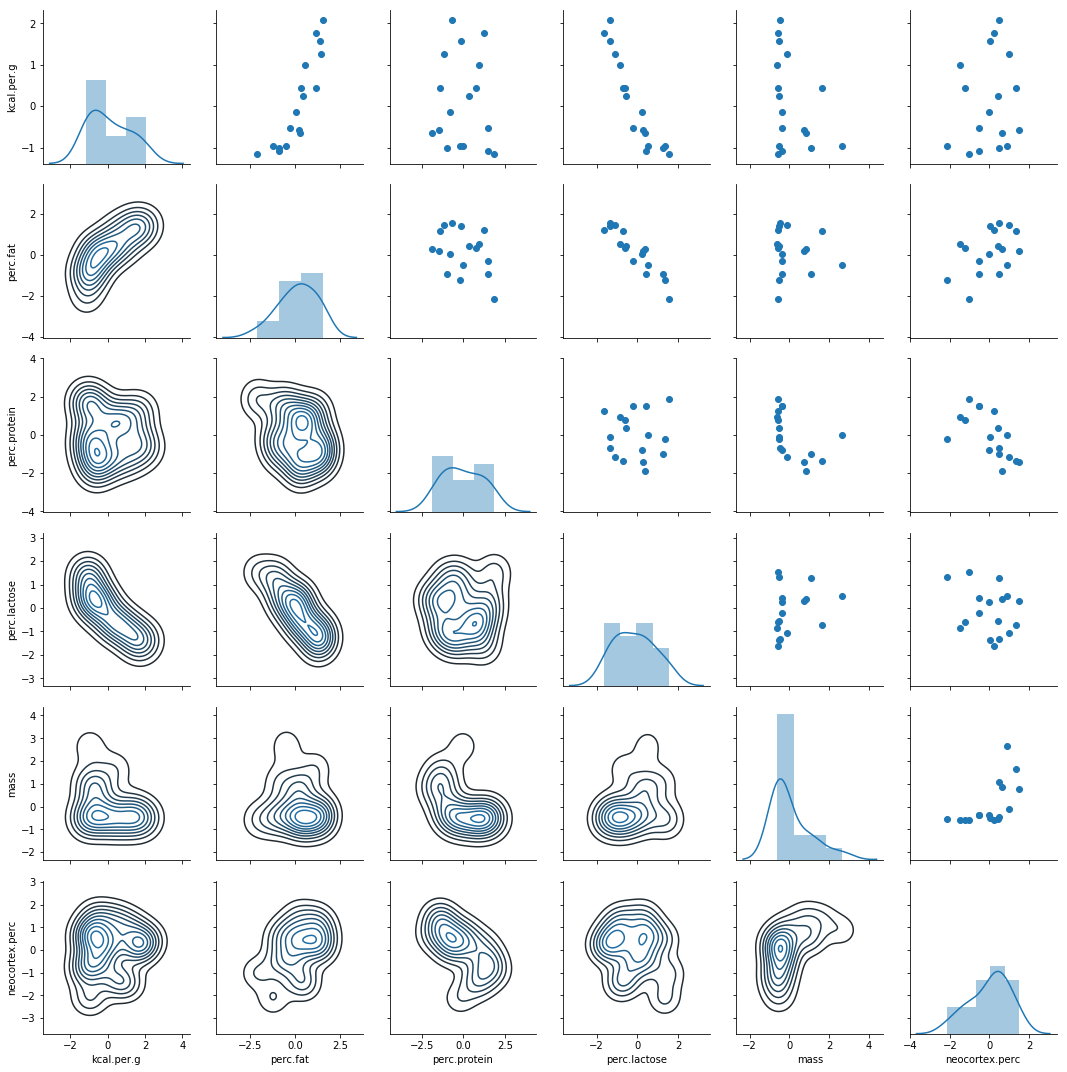

In [9]:
milk_scaled = milk.copy()
for x in milk.columns[2:]:  
  mu, sigma = [np.mean(milk[x]), np.std(milk[x])]
  milk_scaled[x] = [(v - mu) / sigma for v in milk[x].values]
  

g = sns.PairGrid(milk_scaled.dropna(), vars = milk_scaled.columns[2:])
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.distplot)

There are a couple of very obvious relationships here:  

  - `kcal.per.g` (i.e. the amount of energy per gram) has a strong positive relationship with `perc.fat` (the fat percentage)  
  - there is a strong negative relationship between the the amount of fat and the amount of lactose per gram (which again, makes a lot of sense)   
  - note, that there are a bunch of NaN values in the `neocortex.perc` column, which we have just dropped for the visualisation here  
  
## Analysis Plan  

We're going to follow McElreath's analysis of these data. In particular, McElreath uses the relationships between `kcal.per.g`, `mass` and `neocortex.perc` to explore confounding / masked relationships. It's really quite interesting!

The central hypothesis is, that "primates with bigger brains produce more energetic milk, so that brains can grow quickly" (pg. 135, McElreath). McElreath sets out to answer the question, "to what extent energy content of milk is eralted to the percent of the brain mass which is neocortex"?

McElreath follows a logical plan to tackle this question:  

  1. a simple bivariate regression model between `kcal.per.g` and `neocortex.perc`  
  2. a bivariate regression between `kcal.per.g` and `mass`  
  3. a regression model involving all three features  
  
We will follow this same plan, simply reproducing McElreath's results.

### Experiment 1: `kcal.per.g ~ neocrotex.perc`  

This is a reasonably straight-forward model to define. First, we are going to drop rows with missing values (we will extend our analysis to handle this in a future notebook), then we will define the following model via our `joint_l0g_prob()` function:  

$$
kcal.per.g \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta neocrotex.perc \\
\alpha \sim Normal(0, 100) \\
\beta \sim Normal(0, 1) \\
\sigma \sim Uniform(0, 1)
$$


/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


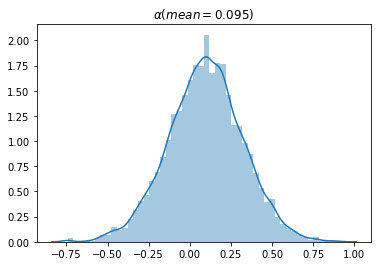

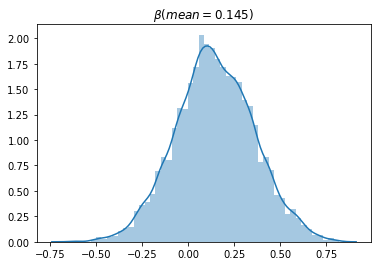

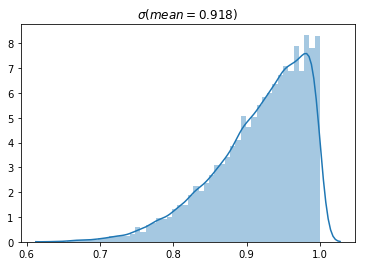

In [31]:
reset_sess()

def joint_log_prob(neocortex, calories, alpha, beta, sigma):
  """
  Model the relationship between energy content and percentage of the
  brain which is neocortex.
  """
  
  prior_alpha = tfd.Normal(0., 100.)
  prior_beta = tfd.Normal(0., 1.)
  prior_sigma = tfd.Uniform(0., 1.)
  
  mu = alpha + beta * neocortex
  rv_calories = tfd.Normal(loc = mu, scale = sigma)
  
  log_lik = (
      prior_alpha.log_prob(alpha) +
      prior_beta.log_prob(beta) +
      prior_sigma.log_prob(sigma) +
      tf.reduce_sum(rv_calories.log_prob(calories))
  )
  
  return log_lik

def unnormalised_posterior(alpha, beta, sigma):
  return joint_log_prob(neocortex, calories, alpha, beta, sigma)

# drop NA rows
milk_scaled.dropna(inplace = True)

# setup variables
# NOTE: the dtype declarations are necessary, otherwise it throws
#       a datatype error
[calories, neocortex] = [
    tf.convert_to_tensor(milk_scaled['kcal.per.g'].values, dtype=np.float32),
    tf.convert_to_tensor(milk_scaled['neocortex.perc'].values, dtype=np.float32)
]

# run our chain
[alpha_, beta_, sigma_] = run_chain(
    construct_hmc(unnormalised_posterior, adaptation_steps = 5000),
    inits = [0.1, 0.1, 0.1],
    iters = [20000, 10000]
)

sns.distplot(alpha_, label = "posterior")
plt.title("$\\alpha (mean = {:.3f})$".format(np.mean(alpha_)))
plt.show()

sns.distplot(beta_, label = "posterior")
plt.title("$\\beta (mean = {:.3f})$".format(np.mean(beta_)))
plt.show()

sns.distplot(sigma_, label = "posterior")
plt.title("$\\sigma (mean = {:.3f})$".format(np.mean(sigma_)))
plt.show()



These results are very similar to those that McElreath reports. Specifically, McElreath reports the following effect size:  

In [20]:
pd.DataFrame({
    'Parameter': ['alpha', 'beta', 'sigma'],
    'Lower 89% Credible Interval': [-0.399, -0.007, 0.120],
    'Mean Estimate': [0.353, 0.005, 0.166],
    'Upper 89% Credible Interval': [1.106, 0.016, 0.211]
})

,Parameter,Lower 89% Credible Interval,Mean Estimate,Upper 89% Credible Interval
0,alpha,-0.399,0.353,1.106
1,beta,-0.007,0.005,0.016
2,sigma,0.120,0.166,0.211


Notice that the estimates of the mean effect size differ between what we report and what McElreath reports. However, the slient point here is that both our results and McElreath's posteriors have a lot of posterior weight either side of zero. These are non-significant effects. 

Another reason for subtle differences, might be that we used scaled values for our data. I tried to run this without scaling the data, and the chains didn't converge well at all. It looks like tensorflow probability might be really sensitive to the scaling. This is something to keep in mind in the future.

**Conclusions**:   
  - this first experiment suggests that there is no correlation between the energy content and size of the neocortex.  
  - looking back up at the pairs plot, this seems reasonable. There might be a weak positive correlation in the plot, but it isn't visually strong  
  



### Experiment 2: `kcal.per.g ~ mass`

Next then, McElreath changes tack a little to see if the total brain mass correlates with the energy content. Specifically, we will model the logarithm of mass (which means I need to use unscaled values initially). McElreath explains: "It is often true that scaling measurements like body mass are related by magnitudes to other variables" (pg. 136), which is why we are taking the logarithm. 

This will be interesting, I will first attempt to run the model with unscaled features, and if that doesn't work we will run it again with scaled features.

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


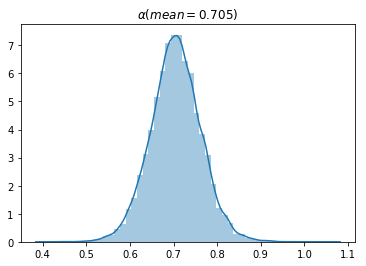

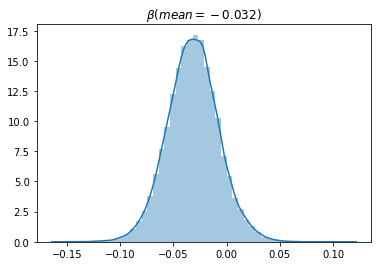

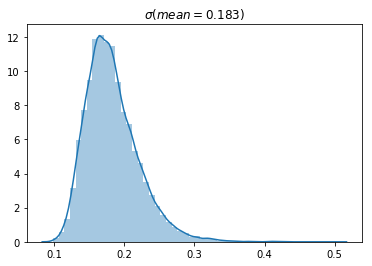

In [36]:
reset_sess()

def joint_log_prob(mass, calories, alpha, beta, sigma):
  """
  Model the relationship between energy content and percentage of the
  brain which is neocortex.
  """
  
  prior_alpha = tfd.Normal(0., 100.)
  prior_beta = tfd.Normal(0., 1.)
  prior_sigma = tfd.Uniform(0., 1.)
  
  mu = alpha + beta * mass
  rv_calories = tfd.Normal(loc = mu, scale = sigma)
  
  log_lik = (
      prior_alpha.log_prob(alpha) +
      prior_beta.log_prob(beta) +
      prior_sigma.log_prob(sigma) +
      tf.reduce_sum(rv_calories.log_prob(calories))
  )
  
  return log_lik

def unnormalised_posterior(alpha, beta, sigma):
  return joint_log_prob(mass, calories, alpha, beta, sigma)

# data prep
unscaled = milk.copy()

# setup variables
# NOTE: the dtype declarations are necessary, otherwise it throws
#       a datatype error
[calories, mass] = [
    tf.convert_to_tensor(unscaled['kcal.per.g'].values, dtype=np.float32),
    tf.convert_to_tensor(np.log(unscaled['mass'].values), dtype=np.float32)
]

# run our chain
[alpha_, beta_, sigma_] = run_chain(
    construct_hmc(unnormalised_posterior, adaptation_steps = 5000),
    inits = [1., 1., 0.1],
    iters = [20000, 10000]
)

sns.distplot(alpha_, label = "posterior")
plt.title("$\\alpha (mean = {:.3f})$".format(np.mean(alpha_)))
plt.show()

sns.distplot(beta_, label = "posterior")
plt.title("$\\beta (mean = {:.3f})$".format(np.mean(beta_)))
plt.show()

sns.distplot(sigma_, label = "posterior")
plt.title("$\\sigma (mean = {:.3f})$".format(np.mean(sigma_)))
plt.show()

These chains look like they have converged more (will explore convergence diagnostics in a future notebook). Interesting too, that the model hasn't struggled with the unscaled data this time - perhaps this is because there is a signal in this model (where there really wasn't in the first model).

McElreath reports the following effects:

In [37]:
pd.DataFrame({
    'Parameter': ['alpha', 'beta', 'sigma'],
    'Lower 89% Credible Interval': [0.63, -0.06, 0.11],
    'Mean Estimate': [0.7, -0.03, 0.160],
    'Upper 89% Credible Interval': [0.78, 0.00, 0.2]
})

,Parameter,Lower 89% Credible Interval,Mean Estimate,Upper 89% Credible Interval
0,alpha,0.63,0.70,0.78
1,beta,-0.06,-0.03,0.00
2,sigma,0.11,0.16,0.20


Our results are very, very similar to these. Though our estimate of beta might not be quite as strong as McElreath's. but qualitatively, these are very close.

### Experiment 3: `kcal.per.g ~ mass + neocortex.perc`  

Finally, McElreath explores what happens when both predictors are added to the model. Let's do the same:

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


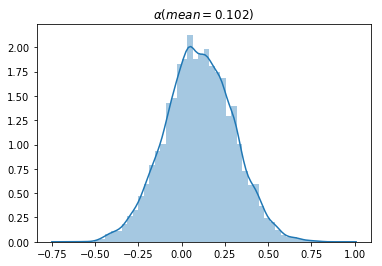

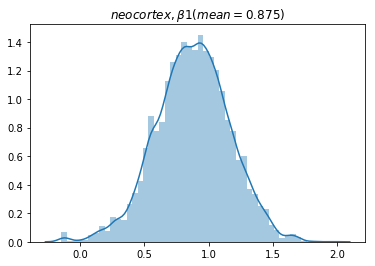

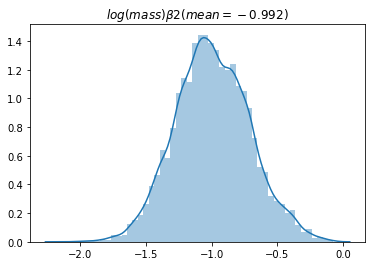

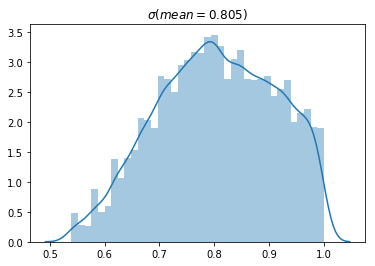

In [45]:
reset_sess()

def joint_log_prob(mass, neocortex, calories, alpha, beta1, beta2, sigma):
  """
  Model the relationship between energy content and percentage of the
  brain which is neocortex.
  """
  
  prior_alpha = tfd.Normal(0., 100.)
  prior_beta1 = tfd.Normal(0., 1.)
  prior_beta2 = tfd.Normal(0., 1.)
  prior_sigma = tfd.Uniform(0., 1.)
  
  mu = alpha + beta1 * neocortex + beta2 * mass
  rv_calories = tfd.Normal(loc = mu, scale = sigma)
  
  log_lik = (
      prior_alpha.log_prob(alpha) +
      prior_beta1.log_prob(beta1) +
      prior_beta2.log_prob(beta2) +
      prior_sigma.log_prob(sigma) +
      tf.reduce_sum(rv_calories.log_prob(calories))
  )
  
  return log_lik

def unnormalised_posterior(alpha, beta1, beta2, sigma):
  return joint_log_prob(mass, neocortex, calories, alpha, beta1, beta2, sigma)

# data prep
# Log and scale the mass
milk_scaled['mass'] = [np.log(x) for x in milk.mass]
mu, sigma = [np.mean(milk_scaled.mass), np.std(milk_scaled.mass)]
milk_scaled['mass'] = [(x - mu) / sigma for x in milk_scaled.mass]

# setup variables
# NOTE: the dtype declarations are necessary, otherwise it throws
#       a datatype error
[mass, neocortex, calories] = [
    tf.convert_to_tensor(milk_scaled['mass'], dtype=np.float32),
    tf.convert_to_tensor(milk_scaled['neocortex.perc'].values, dtype=np.float32),
    tf.convert_to_tensor(milk_scaled['kcal.per.g'].values, dtype=np.float32)
]

# run our chain
[alpha_, beta1_, beta2_, sigma_] = run_chain(
    construct_hmc(unnormalised_posterior, adaptation_steps = 5000),
    inits = [0.0, 0.0, 0.0, 0.5],
    iters = [20000, 10000]
)

sns.distplot(alpha_, label = "posterior")
plt.title("$\\alpha (mean = {:.3f})$".format(np.mean(alpha_)))
plt.show()

sns.distplot(beta1_, label = "posterior")
plt.title("$neocortex, \\beta1 (mean = {:.3f})$".format(np.mean(beta1_)))
plt.show()

sns.distplot(beta2_, label = "posterior")
plt.title("$log(mass) \\beta2 (mean = {:.3f})$".format(np.mean(beta2_)))
plt.show()

sns.distplot(sigma_, label = "posterior")
plt.title("$\\sigma (mean = {:.3f})$".format(np.mean(sigma_)))
plt.show()

McElreath's results were as follow:

In [46]:
pd.DataFrame({
    'Parameter': ['alpha', 'beta1', 'beta2', 'sigma'],
    'Lower 89% Credible Interval': [-1.83, 0.02, -0.13, 0.08],
    'Mean Estimate': [-1.09, 0.03, -0.10, 0.11],
    'Upper 89% Credible Interval': [-0.34, 0.04, -0.06, 0.15]
})

,Parameter,Lower 89% Credible Interval,Mean Estimate,Upper 89% Credible Interval
0,alpha,-1.83,-1.09,-0.34
1,beta1,0.02,0.03,0.04
2,beta2,-0.13,-0.10,-0.06
3,sigma,0.08,0.11,0.15


Our results are very different from these. For clarity, I have displayed our results below:

In [48]:
alpha = np.round([np.percentile(alpha_, 5.5), np.mean(alpha_), np.percentile(alpha_, 94.5)], 3)
beta1 = np.round([np.percentile(beta1_, 5.5), np.mean(beta1_), np.percentile(beta1_, 94.5)], 3)
beta2 = np.round([np.percentile(beta2_, 5.5), np.mean(beta2_), np.percentile(beta2_, 94.5)], 3)
sigma = np.round([np.percentile(sigma_, 5.5), np.mean(sigma_), np.percentile(sigma_, 94.5)], 3)

pd.DataFrame({
    'Parameter': ['alpha', 'beta1', 'beta2', 'sigma'],
    'Lower 89% Credible Interval': [alpha[0], beta1[0], beta2[0], sigma[0]],
    'Mean Estimate': [alpha[1], beta1[1], beta2[1], sigma[1]],
    'Upper 89% Credible Interval': [alpha[2], beta1[2], beta2[2], sigma[2]]
})

,Parameter,Lower 89% Credible Interval,Mean Estimate,Upper 89% Credible Interval
0,alpha,-0.212,0.102,0.416
1,beta1,0.428,0.875,1.327
2,beta2,-1.434,-0.992,-0.526
3,sigma,0.626,0.805,0.972


Why might these be so different? Let's talk about this... 

  - the direction of effects for neocortex and mass are the same in McElreath's and our results. However, the effect sizes are much larger in our results than they are in McElreath's  
  - the intercept term is non-significant in our results, but was significant in McElreath's
  
WHAAAAAT?

I think that what we are seeing here are the effects of "masking" which McElreath was illustrating with this example. It turns out that `neocortex` and `mass` are negatively correlated. They effectively cancel each other out. And that is what we are seeing in the estimated effects - they are cancelling each other out. In this sense, our results *do* agree with McElreath's, and given this intepretation, the exact effect size is now somewhat meaningless.

### Final thoughts  

Interesting that the results I got were consistent with McElreath's, but not exactly the same. In contrast, the [BRMS reproduction](https://bookdown.org/ajkurz/Statistical_Rethinking_recoded/multivariate-linear-models.html#masked-relationship) was able to replicate the results exactly.

I found that tensorflow probability is sensitive to scaling, particularly when there are not clear and significant effects. However, when there is a clear signal, tensorflow probability arrives there as expected. 

This is slightly niggly, but it does mean that we need to be a bit self-critical of our results and make sure that we can reproduce them, at least until I grow my skills with tensorflow probabilty and I get a better understanding of what to watch out for.

Along similar lines, I will definitely need to explore convergence diagnostics in tensorflow probability.